## single class dcgan

In [1]:
import time
import glob
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import imageio
import pandas as pd
from IPython import display

In [85]:
cifar10 = tf.keras.datasets.cifar10
(X_train, y_train), (X_test, _) = cifar10.load_data()
df = pd.DataFrame(list(zip(X_train, y_train)), columns=['image', 'label'])
df = df[df['label']==0]
X_train = np.array([i for i in list(df['image'])])

In [86]:
print(X_train.shape)
print(X_test.shape)

(5000, 32, 32, 3)
(10000, 32, 32, 3)


In [87]:
buffer_size = 5000
batch_size = 256
noise_dim = 100

In [88]:
X_train = (X_train-127.5)/127.5
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size).batch(batch_size)

In [89]:
generator = tf.keras.models.Sequential()
generator.add(tf.keras.layers.Dense(4*4*256, input_shape=(noise_dim,)))
generator.add(tf.keras.layers.LeakyReLU(alpha=0.2))
generator.add(tf.keras.layers.Reshape((4, 4, 256)))
generator.add(tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
generator.add(tf.keras.layers.LeakyReLU(alpha=0.2))
generator.add(tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
generator.add(tf.keras.layers.LeakyReLU(alpha=0.2))
generator.add(tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
generator.add(tf.keras.layers.LeakyReLU(alpha=0.2))
generator.add(tf.keras.layers.Conv2D(3, (3,3), activation='tanh', padding='same'))

generator.summary()

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 4096)              413696    
_________________________________________________________________
leaky_re_lu_148 (LeakyReLU)  (None, 4096)              0         
_________________________________________________________________
reshape_17 (Reshape)         (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_75 (Conv2DT (None, 8, 8, 128)         524416    
_________________________________________________________________
leaky_re_lu_149 (LeakyReLU)  (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_76 (Conv2DT (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_150 (LeakyReLU)  (None, 16, 16, 128)     

In [90]:
discriminator = tf.keras.models.Sequential()
discriminator.add(tf.keras.layers.Conv2D(64, (3,3), padding='same', input_shape=(32, 32, 3)))
discriminator.add(tf.keras.layers.LeakyReLU(alpha=0.2))
discriminator.add(tf.keras.layers.Conv2D(128, (3,3), strides=(2,2), padding='same'))
discriminator.add(tf.keras.layers.LeakyReLU(alpha=0.2))
discriminator.add(tf.keras.layers.Conv2D(128, (3,3), strides=(2,2), padding='same'))
discriminator.add(tf.keras.layers.LeakyReLU(alpha=0.2))
discriminator.add(tf.keras.layers.Conv2D(256, (3,3), strides=(2,2), padding='same'))
discriminator.add(tf.keras.layers.LeakyReLU(alpha=0.2))
discriminator.add(tf.keras.layers.Flatten())
discriminator.add(tf.keras.layers.Dropout(0.4))
discriminator.add(tf.keras.layers.Dense(1, activation='sigmoid'))

discriminator.summary()

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_72 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_152 (LeakyReLU)  (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_153 (LeakyReLU)  (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 8, 8, 128)         147584    
_________________________________________________________________
leaky_re_lu_154 (LeakyReLU)  (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 4, 4, 256)       

In [91]:
cross_entropy = tf.keras.losses.BinaryCrossentropy
def generate_loss(fake_output):
    return cross_entropy(from_logits=True)(tf.ones_like(fake_output), fake_output)

def dicriminate_loss(real_output, fake_output):
    real_loss = cross_entropy(from_logits=True)(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(from_logits=True)(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [92]:
@tf.function
def train_step(images):
    noise = tf.random.normal((batch_size, noise_dim))
    
    with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:
        generated_image = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_image, training=True)
        
        generator_loss = generate_loss(fake_output)
        discriminator_loss = dicriminate_loss(real_output, fake_output)
        
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)
        
    generator_grad = generator_tape.gradient(generator_loss, generator.trainable_variables)
    discriminator_grad = discriminator_tape.gradient(discriminator_loss, discriminator.trainable_variables)
        
    generator_optimizer.apply_gradients(zip(generator_grad, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_grad, discriminator.trainable_variables))
        
    return real_accuracy, fake_accuracy, generator_loss, discriminator_loss

In [93]:
seed = tf.random.normal((25, noise_dim))

In [94]:
def generate_and_save_images(model, epoch, it, sample_seeds):
    predictions = model(sample_seeds, training=False)
    pred_image = predictions.numpy()
    pred_image = (pred_image*127.5)+127.5
    pred_image = pred_image.astype(int)
    
    fig = plt.figure(figsize=(10, 10))
    for i in range(pred_image.shape[0]):
        plt.subplot(5, 5, i+1)
        plt.imshow(pred_image[i, :, :, :])
        plt.axis("off")
   
    plt.savefig("/aiffel/aiffel/dcgan_newimage/cifar10/single_class_gan/{}.png".format(epoch))
    plt.show()

In [95]:
def train(dataset, epochs=70):
    start = time.time()
    history = {"real_accuracy":[], "fake_accuracy":[], "generator_loss":[], "discriminator_loss":[]}
    
    for epoch in range(epochs):
        epoch_start = time.time()
        for i, image_batch in enumerate(dataset):
            real_accuracy, fake_accuracy, generator_loss, discriminator_loss = train_step(image_batch)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)
            history['generator_loss'].append(generator_loss)
            history['discriminator_loss'].append(discriminator_loss)

            if i % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, i+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, i+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, i, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

    real_accuracy = history["real_accuracy"]
    fake_accuracy = history["fake_accuracy"]
    gernerator_loss = history["generator_loss"]
    discriminator_loss = history["discriminator_loss"]

    plt.plot(real_accuracy, label="real_accuracy")
    plt.plot(fake_accuracy, label="fake_accuracy")
    plt.title("accuarcy")
    plt.legend()
    plt.show()

    plt.plot(gernerator_loss, label="generator_loss")
    plt.plot(discriminator_loss, label="discriminator_loss")
    plt.title("loss")
    plt.legend()
    plt.show()

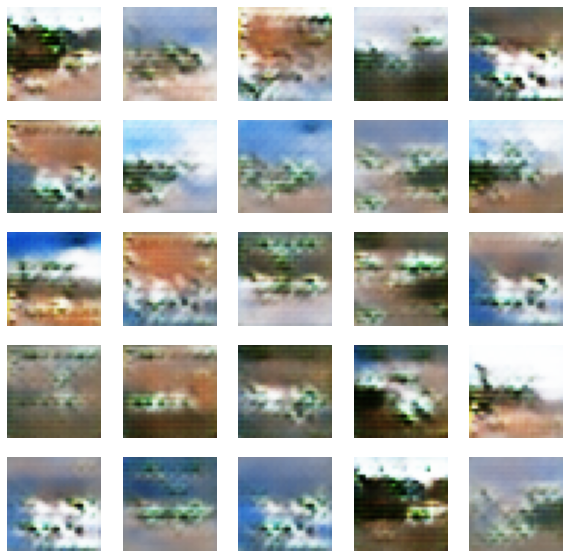

Time for training : 2907 sec


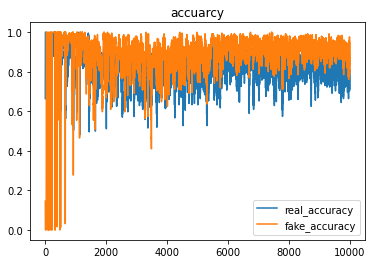

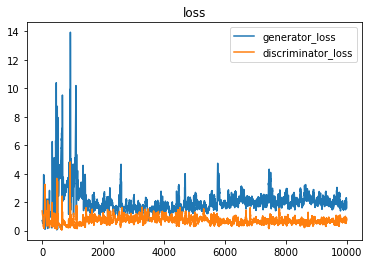

In [96]:
import warnings
warnings.filterwarnings('ignore')

train(train_dataset, 500)

In [2]:
anim_file = "/aiffel/aiffel/dcgan_newimage/cifar10/single_class_gan.gif"

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob("/aiffel/aiffel/dcgan_newimage/cifar10/single_class_gan/*.png")
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l /aiffel/aiffel/dcgan_newimage/cifar10/single_class_gan.gif

-rw-r--r-- 1 root root 7177066 Jan 25 00:32 /aiffel/aiffel/dcgan_newimage/cifar10/single_class_gan.gif


## multi class dcgan

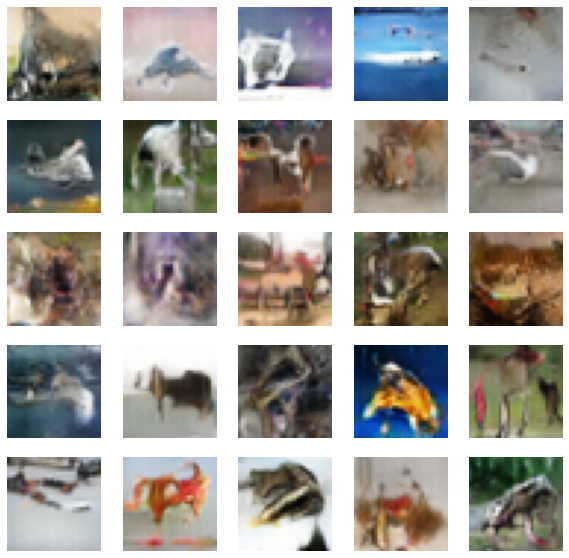

Time for training : 18735 sec


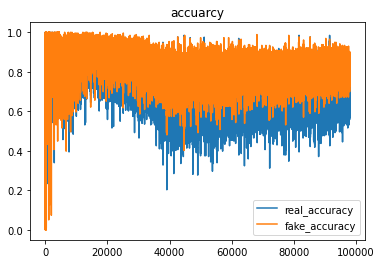

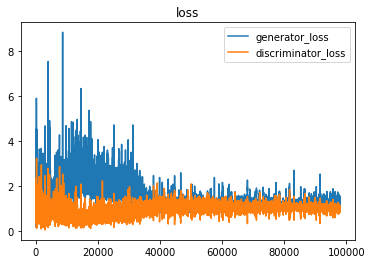

In [101]:
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import imageio
from IPython import display


buffer_size = 30000
batch_size = 256
noise_dim = 100

cross_entropy = tf.keras.losses.BinaryCrossentropy
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


def generate_loss(fake_output):
    return cross_entropy(from_logits=True)(tf.ones_like(fake_output), fake_output)


def dicriminate_loss(real_output, fake_output):
    real_loss = cross_entropy(from_logits=True)(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(from_logits=True)(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss


def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy


def generate_and_save_images(model, epoch, it, sample_seeds):
    pred_image = model.predict(sample_seeds)
    pred_image = (pred_image*127.5)+127.5
    pred_image = pred_image.astype(int)
    
    fig = plt.figure(figsize=(10, 10))
    for i in range(pred_image.shape[0]):
        plt.subplot(5, 5, i+1)
        plt.imshow(pred_image[i, :, :, :])
        plt.axis("off")
   
    plt.savefig("/aiffel/aiffel/dcgan_newimage/cifar10/multi_class_gan_image/{}.png".format(epoch))
    plt.show()
 

@tf.function
def train_step(images):
    noise = tf.random.normal((batch_size, noise_dim))
    
    with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:
        generated_image = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_image, training=True)
        
        generator_loss = generate_loss(fake_output)
        discriminator_loss = dicriminate_loss(real_output, fake_output)
        
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)
        
    generator_grad = generator_tape.gradient(generator_loss, generator.trainable_variables)
    discriminator_grad = discriminator_tape.gradient(discriminator_loss, discriminator.trainable_variables)
        
    generator_optimizer.apply_gradients(zip(generator_grad, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_grad, discriminator.trainable_variables))
        
    return real_accuracy, fake_accuracy, generator_loss, discriminator_loss
    
    
def train(dataset, epochs=70):
    start = time.time()
    history = {"real_accuracy":[], "fake_accuracy":[], "generator_loss":[], "discriminator_loss":[]}
    
    for epoch in range(epochs):
        epoch_start = time.time()
        for i, image_batch in enumerate(dataset):
            real_accuracy, fake_accuracy, generator_loss, discriminator_loss = train_step(image_batch)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)
            history['generator_loss'].append(generator_loss)
            history['discriminator_loss'].append(discriminator_loss)

            if i % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, i+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, i+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, i, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

    real_accuracy = history["real_accuracy"]
    fake_accuracy = history["fake_accuracy"]
    gernerator_loss = history["generator_loss"]
    discriminator_loss = history["discriminator_loss"]

    plt.plot(real_accuracy, label="real_accuracy")
    plt.plot(fake_accuracy, label="fake_accuracy")
    plt.title("accuarcy")
    plt.legend()
    plt.show()

    plt.plot(gernerator_loss, label="generator_loss")
    plt.plot(discriminator_loss, label="discriminator_loss")
    plt.title("loss")
    plt.legend()
    plt.show()
    

warnings.filterwarnings('ignore')

cifar10 = tf.keras.datasets.cifar10
(X_train,_), (X_test, _) = cifar10.load_data()

X_train = (X_train-127.5)/127.5
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size).batch(batch_size)

generator = tf.keras.models.Sequential()
generator.add(tf.keras.layers.Dense(4*4*256, input_shape=(noise_dim,)))
generator.add(tf.keras.layers.LeakyReLU(alpha=0.2))
generator.add(tf.keras.layers.Reshape((4, 4, 256)))
generator.add(tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
generator.add(tf.keras.layers.LeakyReLU(alpha=0.2))
generator.add(tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
generator.add(tf.keras.layers.LeakyReLU(alpha=0.2))
generator.add(tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
generator.add(tf.keras.layers.LeakyReLU(alpha=0.2))
generator.add(tf.keras.layers.Conv2D(3, (3,3), activation='tanh', padding='same'))

discriminator = tf.keras.models.Sequential()
discriminator.add(tf.keras.layers.Conv2D(64, (3,3), padding='same', input_shape=(32, 32, 3)))
discriminator.add(tf.keras.layers.LeakyReLU(alpha=0.2))
discriminator.add(tf.keras.layers.Conv2D(128, (3,3), strides=(2,2), padding='same'))
discriminator.add(tf.keras.layers.LeakyReLU(alpha=0.2))
discriminator.add(tf.keras.layers.Conv2D(128, (3,3), strides=(2,2), padding='same'))
discriminator.add(tf.keras.layers.LeakyReLU(alpha=0.2))
discriminator.add(tf.keras.layers.Conv2D(256, (3,3), strides=(2,2), padding='same'))
discriminator.add(tf.keras.layers.LeakyReLU(alpha=0.2))
discriminator.add(tf.keras.layers.Flatten())
discriminator.add(tf.keras.layers.Dropout(0.4))
discriminator.add(tf.keras.layers.Dense(1, activation='sigmoid'))

seed = tf.random.normal((25, noise_dim))

train(train_dataset, 500)

In [3]:
anim_file = "/aiffel/aiffel/dcgan_newimage/cifar10/multi_class_gan.gif"

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob("/aiffel/aiffel/dcgan_newimage/cifar10/multi_class_gan_image/*.png")
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l /aiffel/aiffel/dcgan_newimage/cifar10/single_class_gan.gif

-rw-r--r-- 1 root root 7177066 Jan 25 00:32 /aiffel/aiffel/dcgan_newimage/cifar10/single_class_gan.gif


## 결론

### gan의 경우 직관적으로 와닿지 않아서 조금 까다로웠던 노드였습니다
### single class야 어느정도 비스무리한건 만들어 진거 같은데 멀티클래스는 뭐가 안나와서 처음엔 조금 당황스웠습니다. 하지만 원래 그렇다고 하니..
### 처음 전략은 바이너리엔트로피를 쓰기 때문에 멀티클래스에서는 dcgan이 힘들다고 판단해서 로스펑션을 고치는 방향으로 설계를 했습니다. 라벨을 버리지 않고 갖고와서 원핫인코딩으로 로스펑션 수정하면 되지않을까 라는게 초기 아이디어였습니다. 해서 multi calss gan으로 스칼라 뒤져보니 관련 논문 몇개가 나왔습니다. 뭐 요약만 읽었을때는 semi unsupervised model이라고 하니 아마도 처음 아이디어와 비슷한 접근방식이지 않을까 싶은데.. 문제는 논문의 수식만 봐서는 코드구현이 안되는 한계가 있... 슈도코드라도 쫌 주든가 하지ㅠㅠㅠ
### 어쨌든 세미 비지도 방식으로 여러가지 시도해보다가 안되겠다 싶어서 더 찾아보니 cifar10정도는 생성자와 판별자만 적당히 수정해도 충분히 성능을 낼 수 있다는 걸 알았습니다. 다른 분들 코드도 참고했구요. 그랬더니 그것 만으로도 어느정도는 비스무리한 이미지를 생성할 수 있었습니다.
### 단일클래스갠의 경우 300에폭 이상부터 어느 정도 비행기다 라는걸 확인 할 수 있을 정도로 이미지가 출력되었고 멀티클래스의 경우 더 구체적인 이미지가 나오긴하는데 솔직히 뭔지는 잘 모르겠습니다. 32*32픽셀짜리를 너무 크게 뽑아서 그런가 강아지처럼 보이기도 하고 비행기처럼 보이기도하고 뭐.. 문제를 생성자가 10개 클래스의 이미지를 모두 잘 생성하는지 판단이 안된다는 점에 있습니다. 쫌 여러개 뽑아서 봐야되는데 수치적으로 구분할 수 있는 척도가 없다는 근본적 문제가 있습니다
### 어쨋든 연휴기간에 하는 거라 이정도에서 만족하고 접기로 합시다ㅎ